In [2]:
#MODEL 1
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

x_train = tf.reshape(tf.cast(x_train, tf.float32), [-1,28*28])
x_test = tf.reshape(tf.cast(x_test, tf.float32), [-1,28*28])

y_train = to_categorical(y_train, 10)


In [4]:
class DenseNN(tf.Module):
    def __init__(self, outputs, activate = 'relu'):
        super().__init__()
        self.outputs = outputs
        self.activate = activate
        self.fl_init = False
    def __call__(self, x):
        if not self.fl_init:
            self.w = tf.random.truncated_normal((x.shape[-1],self.outputs),stddev = 0.1, name = 'w')
            self.b = tf.zeros([self.outputs],dtype = tf.float32, name = 'b')
            
            self.w = tf.Variable(self.w)
            self.b = tf.Variable(self.b)
            
            self.fl_init = True
            
        y = x @ self.w + self.b
        if self.activate == 'relu':
            return tf.nn.relu(y)
        elif self.activate == 'softmax':
            return tf.nn.softmax(y)
        return y       

In [6]:
class SequantialModule(tf.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = DenseNN(128)
        self.layer_2 = DenseNN(10, activate = 'softmax')
        
    def __call__(self, x):
        return self.layer_2(self.layer_1(x))

In [7]:
model = SequantialModule()
print (model.submodules)

(<__main__.DenseNN object at 0x0000022F04FD9AC0>, <__main__.DenseNN object at 0x0000022F04FD9CA0>)


In [8]:
cross_entropy = lambda y_true, y_pred: tf.reduce_mean(tf.losses.categorical_crossentropy(y_true,y_pred))
opt = tf.optimizers.Adam(learning_rate = 0.001)


In [9]:
total = x_train.shape[0] # Total number of samples in the training data
num_classes = 10 # Total number of classes, in our case, it's digits from 0 to 9
learning_rate = 0.001 # The learning rate of the neural network training
training_steps = 20 # The maximum number of epochs
batch_size = 256 # The batch size used for training

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size = 1024).batch(batch_size)

In [11]:
for n in range(num_classes):
    loss = 0
    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            f_loss = cross_entropy(y_batch, model(x_batch))
        loss += f_loss
        grads = tape.gradient(f_loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        dt_loss = loss.numpy()
    print (dt_loss)
y = model(x_test)
y2 = tf.argmax(y, axis = 1).numpy()
acc = len(y_test[y_test == y2])/y_test.shape[0]*100
print('Accuracy of trained neural network',acc) 

116.702126
49.781128
36.84428
29.709475
24.439156
20.777891
17.839722
15.724491
13.906134
12.2632475
Accuracy of trained neural network 97.32


In [12]:
def plot_images(images, cls_true, cls_pred=None, correct = True, title=None):
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    i = 0 
    for j, ax in enumerate(axes.flat):
        while True:
            if (cls_true[i] == cls_pred[i]) == correct:
                break
            i+=1    
        ax.set_title('Example %d. Label: %d' % (i, cls_pred[i]))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(images[i].reshape(28, 28), cmap='binary')
        i+=1
    if title:
        plt.suptitle(title, size=20)
    plt.show(block=False)

def plot_example_errors(images, cls_true, cls_pred, title):
    np_array_errors = np.equal(cls_pred, cls_true, dtype=object)
    error_images = []
    predicted_values = []
    correct_values = []
    for i in range(0, np_array_errors.shape[0]):
        if not np_array_errors[i]:
            error_images.append(images[i])
            predicted_values.append(cls_pred[i])
            correct_values.append(cls_true[i])
    plot_images(error_images, correct_values, predicted_values, correct = False, title='Misclassified Examples')
            

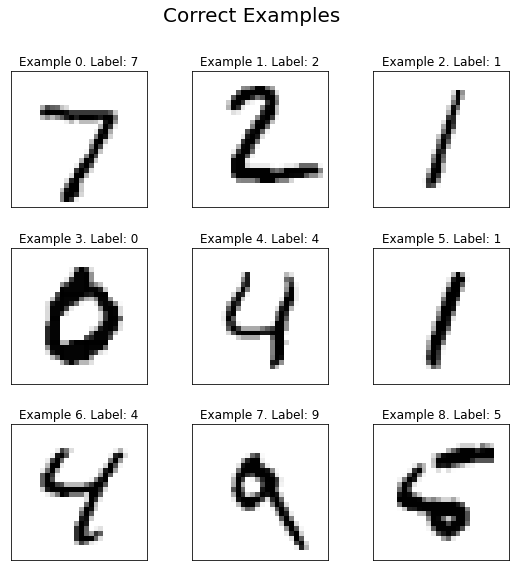

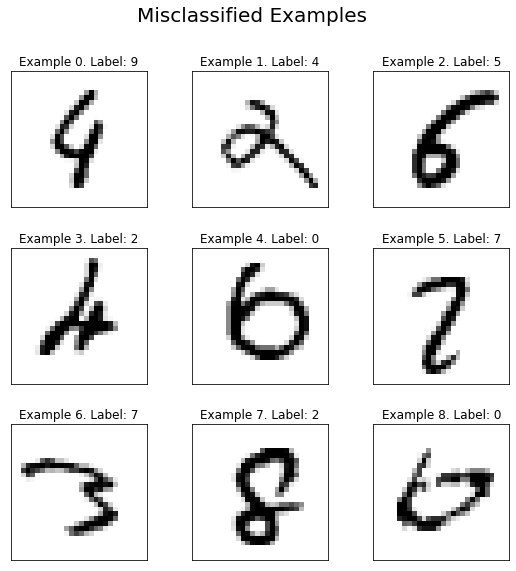

In [13]:
cls_true = y_test
cls_pred = y2
plot_images(x_test, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(x_test, cls_true, cls_pred, title='Misclassified Examples')
plt.show()

In [ ]:
#Model 2

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Завантаження та підготовка даних
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = tf.reshape(tf.cast(x_train, tf.float32), [-1, 28 * 28])
x_test = tf.reshape(tf.cast(x_test, tf.float32), [-1, 28 * 28])

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Визначення моделі нейронної мережі зі зменшеною розмірністю (менше нейронів)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Функція втрат та оптимізатор
cross_entropy = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)  # Зменшили швидкість навчання

# Параметри навчання
num_epochs = 20
batch_size = 256
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Навчання моделі
for epoch in range(num_epochs):
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        with tf.GradientTape() as tape:
            y_pred = model(x_batch)
            loss = cross_entropy(y_batch, y_pred)

        gradients = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients, model.trainable_variables))

    # Обчислення точності та функції втрат на навчальних та тестових даних
    y_train_pred = model(x_train)
    train_loss = cross_entropy(y_train, y_train_pred)
    train_accuracy = np.mean(np.argmax(y_train, axis=1) == np.argmax(y_train_pred, axis=1))

    y_test_pred = model(x_test)
    test_loss = cross_entropy(y_test, y_test_pred)
    test_accuracy = np.mean(np.argmax(y_test, axis=1) == np.argmax(y_test_pred, axis=1))

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



Epoch 1/20, Train Loss: 0.3668, Train Accuracy: 0.9002, Test Loss: 0.3532, Test Accuracy: 0.9048
Epoch 2/20, Train Loss: 0.2767, Train Accuracy: 0.9234, Test Loss: 0.2719, Test Accuracy: 0.9244
Epoch 3/20, Train Loss: 0.2350, Train Accuracy: 0.9343, Test Loss: 0.2352, Test Accuracy: 0.9336
Epoch 4/20, Train Loss: 0.2063, Train Accuracy: 0.9429, Test Loss: 0.2100, Test Accuracy: 0.9408
Epoch 5/20, Train Loss: 0.1842, Train Accuracy: 0.9491, Test Loss: 0.1906, Test Accuracy: 0.9460
Epoch 6/20, Train Loss: 0.1669, Train Accuracy: 0.9539, Test Loss: 0.1754, Test Accuracy: 0.9498
Epoch 7/20, Train Loss: 0.1531, Train Accuracy: 0.9574, Test Loss: 0.1637, Test Accuracy: 0.9525
Epoch 8/20, Train Loss: 0.1415, Train Accuracy: 0.9606, Test Loss: 0.1541, Test Accuracy: 0.9560
Epoch 9/20, Train Loss: 0.1315, Train Accuracy: 0.9639, Test Loss: 0.1462, Test Accuracy: 0.9569
Epoch 10/20, Train Loss: 0.1228, Train Accuracy: 0.9664, Test Loss: 0.1394, Test Accuracy: 0.9585
Epoch 11/20, Train Loss: 0.11

In [5]:
from sklearn.metrics import classification_report

# Getting predicted classes for the test data
y_test_pred = model.predict(x_test)
predicted_labels = np.argmax(y_test_pred, axis=1)
true_labels = np.argmax(y_test, axis=1)

#Creating a classification report
report = classification_report(true_labels, predicted_labels)

# Виведення звіту
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.96      0.97      0.97       892
           6       0.98      0.97      0.97       958
           7       0.96      0.97      0.97      1028
           8       0.97      0.94      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



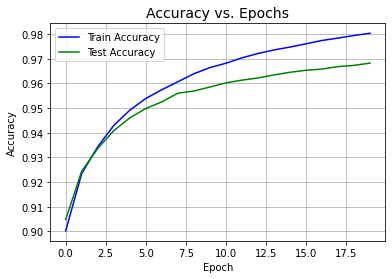

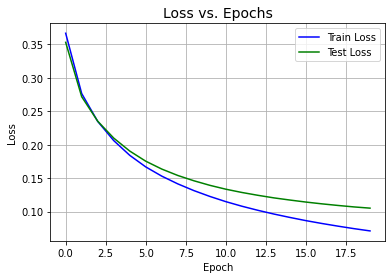

In [25]:
# Відображення графіків точності та функції втрат

# Графік точності
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs', fontsize=14)

# Додавання сітки
plt.grid(True)
plt.show()

# Графік функції втрат
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs', fontsize=14)
# Додавання сітки
plt.grid(True)
plt.show()